# Tema 6 - optionala: MLP definit si antrenat cu PyTorch

Implementati un model de clasificare MLP pentru recunoasterea celor 10 tipuri de cifre din setul MNIST. Implementarea se va face folosind PyTorch. Setul de date va fi un obiect de tip [MNIST Dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html). 

Puteti extinde codul din exemplul PyTorch pentru regresia logistica; trebuie, in principal, sa adaugati straturi ascunse si sa stabiliti functia de eroare. 

Cerinte/observatii:
1. metoda de initializare pentru MLP va primi: numarul de noduri de intrare -- pentru MNIST: 784; numarul de clase de iesire -- 10 in acest caz; numarul de neuroni din straturile ascunse, ca lista de intregi: de exemplu, [300, 150, 40] arata ca avem 3 straturi ascunse, cu cate 300, 150 si respectiv 40 de neuroni.
1. de asemenea, metoda de initializare va primi un indicativ al functiei de activare care se folosesc in straturile ascunse -- [sigmoida logistica](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [tangenta hiperbolica](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html), [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU), [SELU](https://pytorch.org/docs/stable/generated/torch.nn.SELU.html#torch.nn.SELU), [PReLU](https://pytorch.org/docs/stable/generated/torch.nn.PReLU.html#torch.nn.PReLU) [etc](https://pytorch.org/docs/stable/nn.html#id1). Puteti alege ca fiecarui strat ascuns sa ii fie indicata o functie de activare.
1. se va reteaua si sumarul retelei, folosind **[torchinfo](https://github.com/TylerYep/torchinfo)**; de preferat **torchinfo** lui <s>torchsummary</s>.
1. la instantierea obiectului Dataset MNIST se va folosi sirul de transformari indicat mai jos.
1. in functia `forward` a modelului se va face aducerea intrarilor de la forma [B, 1, 28, 28] la [B, 768], unde B este dimensiunea minibatchului; obiectul Dataset MNIST din PyTorch returneaza o cifra ca o matrice de valori, pe un singur canal (imagine in otnuri de gri); functia `forward` va produce o iesire de forma [B, 10], unde cele 10 valori vor fi logitii furnizati ulterior functiei `torch.nn.CrossEntropyLoss`.
1. creati o matrice de confuzie pentru clase; puteti folosi [scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). Experimentati cu diferiti [optimizatori](https://pytorch.org/docs/stable/optim.html).
1. scrieti intr-un tabel valorile de acuratete obtinute pentru setul de antrenare si cel de testare. Folositi cel putin 3 variante de functii de activare in straturile ascunse. Pentru fiecare experiment, prezentati in acelasi grafic loss-ul pe setul antrenare si pe testare si intr-un alt grafic acuratetea pe setul de antrenare si pe cel de testare.

Tema este **optionala**: daca este prezentata, va fi considerata nota suplimentara si contribuie la calculul notei finale. Predarea ei se face in 15 mai 2024, ora 23.

## Incarcarea si transformarea setului de date MNIST

In [66]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchinfo
import torch
from typing import List, Tuple

In [67]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

In [68]:
# subsetul de antrenare
train_ds = MNIST('./data', train=True, download=True, transform=transform)
# pentru subsetul de testare se foloseste `train=False`
test_ds = MNIST('./data', train=False, download=True, transform=transform)

In [69]:
# primul minibatch
for data, label in train_ds:
    print(data.shape, data.min(), data.max())
    break
# fiecare imagine de cifra este o imagine pe un singur canal, matrice de 28x28, valorile initiale 0..255 sunt aduse in [-1, 1] prin transformare

torch.Size([1, 28, 28]) tensor(-1.) tensor(1.)


In [70]:
batch_size = 2**12
train_loader =  DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [71]:
for data, label in train_loader:
    print(data.shape)
    # reshape:
    data = data.view(data.shape[0], -1)
    print(data.shape)
    break

torch.Size([4096, 1, 28, 28])
torch.Size([4096, 784])


In [72]:
def function(func: str, dim: int = 0) -> torch.nn.Module:
    if func == 'relu':
        return torch.nn.ReLU()
    elif func == 'sigmoid':
        return torch.nn.Sigmoid()
    elif func == 'tanh':
        return torch.nn.Tanh()
    elif func == 'elu':
        return torch.nn.ELU()
    elif func == 'leakyrelu':
        return torch.nn.LeakyReLU()
    elif func == 'softmax':
        return torch.nn.Softmax(dim=dim)
    elif func == 'selu':
        return torch.nn.SELU()
    elif func == 'softplus':
        return torch.nn.Softplus()
    elif func == 'prelu':
        return torch.nn.PReLU()
    else:
        raise Exception('Invalid activation function')


class MLP(torch.nn.Module):
    def __init__(self, input_dim: int = 784, outputs_classes: int = 10, neurons: List[int] = [300, 150, 40], func: List[str] = ['relu', 'relu', 'relu']):
        super(MLP, self).__init__()
        self.layers = torch.nn.ModuleList()
        self.function = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(in_features=input_dim, out_features=neurons[0]))
        # self.layers.append(torch.nn.Linear(in_features=neurons[0], out_features=neurons[1]))
        # self.layers.append(torch.nn.Linear(in_features=neurons[1], out_features=neurons[2]))
        # self.layers.append(torch.nn.Linear(in_features=neurons[2], out_features=outputs_classes))
        for i in range(1, len(neurons)):
            self.layers.append(torch.nn.Linear(neurons[i-1], neurons[i]))
        self.layers.append(torch.nn.Linear(neurons[-1], outputs_classes))
        for f in func:
            self.function.append(function(f, dim=1))
    
    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            if i < len(self.layers) - 1 :
                x = self.function[i](x)
        return x

In [73]:
model = MLP(input_dim=784, outputs_classes=10, neurons=[300, 150, 40], func=['relu', 'selu', 'leakyrelu'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)
torchinfo.summary(model, input_size=(batch_size, 784))

cuda


Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [4096, 10]                --
├─ModuleList: 1-7                        --                        (recursive)
│    └─Linear: 2-1                       [4096, 300]               235,500
├─ModuleList: 1-6                        --                        --
│    └─ReLU: 2-2                         [4096, 300]               --
├─ModuleList: 1-7                        --                        (recursive)
│    └─Linear: 2-3                       [4096, 150]               45,150
├─ModuleList: 1-6                        --                        --
│    └─SELU: 2-4                         [4096, 150]               --
├─ModuleList: 1-7                        --                        (recursive)
│    └─Linear: 2-5                       [4096, 40]                6,040
├─ModuleList: 1-6                        --                        --
│    └─LeakyReLU: 2-6                    [4096

In [74]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fn = torch.nn.CrossEntropyLoss()

In [75]:
def accuracy(y_hat: torch.Tensor, y: torch.Tensor) -> float:
    return (y_hat.argmax(1) == y).float().mean()*100

@torch.no_grad()
def test_f(model: torch.nn.Module, test: DataLoader) -> Tuple[float, float]:
    print('Testing...')
    model.eval()
    acc = []
    loss = []
    for data, label in test:
        data = data.to(device)
        label = label.to(device)
        data = data.view(data.shape[0], -1)
        y_hat = model(data)
        acc.append(accuracy(y_hat, label).item())
        loss.append(loss_fn(y_hat, label).item())
    return sum(acc) / len(acc), sum(loss) / len(loss)

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

def train(model, train, test, optimizer, loss_fn, epochs):
    for epoch in range(epochs):
        model.train()
        for data, label in train:
            data = data.to(device)
            label = label.to(device)
            data = data.view(data.shape[0], -1) 
            optimizer.zero_grad() 
            y_hat = model(data)
            loss_train = loss_fn(y_hat, label)
            loss_train.backward()
            optimizer.step()
        acc_test, loss_test = test_f(model, test)
        acc_train = accuracy(y_hat, label)
        
        train_accuracies.append(acc_train)
        train_losses.append(loss_train)
        test_accuracies.append(acc_test)
        test_losses.append(loss_test)
        
        print(f'Epoch {epoch+1}/{epochs}: loss_train={loss_train}, acc_train={acc_train:.2f}%\n\
            loss_test={loss_test}, acc_test={acc_test:.2f}%')

In [76]:
train(model, train_loader, test_loader, optimizer, loss_fn, 100)
 

Testing...
Epoch 1/100: loss_train=1.6607564687728882, acc_train=66.30%
            loss_test=1.5727634032567341, acc_test=67.89%
Testing...
Epoch 2/100: loss_train=0.8225094676017761, acc_train=77.48%
            loss_test=0.754533569018046, acc_test=80.34%
Testing...
Epoch 3/100: loss_train=0.5275843143463135, acc_train=84.94%
            loss_test=0.505140483379364, acc_test=85.52%
Testing...
Epoch 4/100: loss_train=0.4790545105934143, acc_train=86.22%
            loss_test=0.40384111801783246, acc_test=88.86%
Testing...
Epoch 5/100: loss_train=0.3765237331390381, acc_train=90.29%
            loss_test=0.3469283978144328, acc_test=90.27%
Testing...
Epoch 6/100: loss_train=0.3587551712989807, acc_train=89.57%
            loss_test=0.31265367070833844, acc_test=91.20%
Testing...
Epoch 7/100: loss_train=0.3156625032424927, acc_train=91.00%
            loss_test=0.29264216125011444, acc_test=91.43%
Testing...
Epoch 8/100: loss_train=0.31614914536476135, acc_train=90.62%
            loss

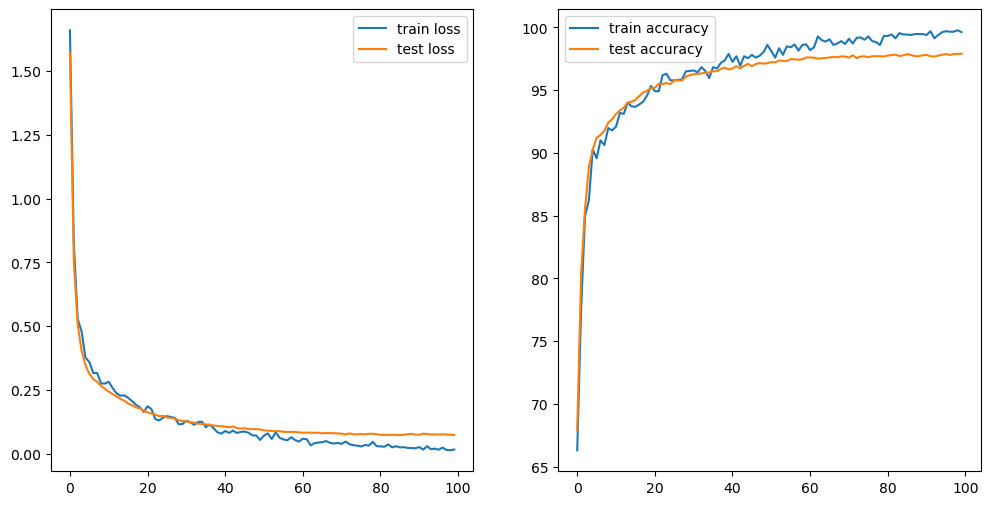

In [77]:
import matplotlib.pyplot as plt

train_losses = [l.cpu().detach().numpy() for l in train_losses]
train_accuracies = [l.cpu().detach().numpy() for l in train_accuracies]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='train accuracy')
plt.plot(test_accuracies, label='test accuracy')
plt.legend()

plt.show()

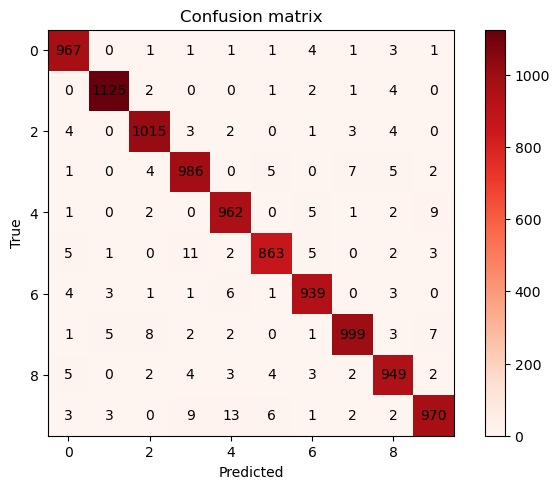

In [78]:
# confussion matrix
from sklearn.metrics import confusion_matrix

model.eval()
y_true = []
y_pred = []
for data, label in test_loader:
    data = data.to(device)
    label = label.to(device)
    data = data.view(data.shape[0], -1)
    y_hat = model(data)
    y_true.extend(label.cpu().numpy())
    y_pred.extend(y_hat.argmax(1).cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, cmap=plt.cm.Reds, interpolation='nearest')
for i in range(10):
    for j in range(10):
        plt.text(j, i, f'{cm[i, j]}', ha='center', va='center')
plt.title('Confusion matrix')
plt.colorbar()
plt.tight_layout()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()